# Advanced Lane Finding (Project 2 - Self-Driving Car Engineer ND)

The goals / steps of this project are the following:

    * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    * Apply a distortion correction to raw images.
    * Use color transforms, gradients, etc., to create a thresholded binary image.
    * Apply a perspective transform to rectify binary image ("birds-eye view").
    * Detect lane pixels and fit to find the lane boundary.
    * Determine the curvature of the lane and vehicle position with respect to center.
    * Warp the detected lane boundaries back onto the original image.
    * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Imports

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpl_img
import glob

test_image = plt.imread("test_images/test5.jpg")
plt.imsave("output_images/original_image.jpg", test_image)

## Camera Calibration


In [4]:
def calibrateCamera():
    """
    Calculates parameters needed for camera calibration with the help of the calibration files
    """
    # Load images from folder camera_cal with the help of the glob library
    images = glob.glob("camera_cal/calibration*.jpg")

    # Arrays to save object~ / image points from all images
    obj_points = []
    img_points = []

    # Preperation of objectpoints 
    objp = np.zeros((6*9,3), np.float32)
    for y in range(6):
        for x in range(9):
            objp[9*y+x] = [x,y,0]

    # Loop over all calibration images
    for image_path in images:
        # Read in image
        image = mpl_img.imread(image_path)

        # Convert Image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        img = cv2.drawChessboardCorners(image, (9,6), corners, ret)

        if ret:
            img_points.append(corners)
            obj_points.append(objp)

    return obj_points, img_points

op, ip = calibrateCamera()

## Image distortion correction

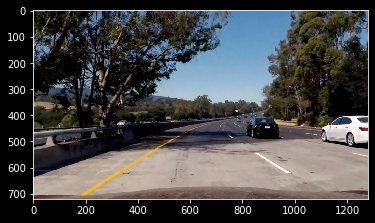

In [5]:
def undistortImage(image, o_points, i_points):
    """
    Undistort Images from a camera
    INPUT: distorted image, object_points, image_points (both from calibrateCamera())
    OUTPUT: undistorted image or error on failure
    """
    # Convert to gray scale
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Calculate Camera matrix and distance coefficients 
    ret, cam_matrix, distance_coeff, rot_vec, trans_vec = cv2.calibrateCamera(o_points, i_points, gray.shape, None, None)
    if ret:
        # return undistorted image
        return cv2.undistort(image, cam_matrix, distance_coeff)
    else:
        # raise error if camera calibration fails
        raise ValueError("Can not undistort the given image!")

undistort_img = undistortImage(test_image, op, ip)
plt.imshow(undistort_img)
plt.imsave("output_images/undistorted_image.jpg", undistort_img)

## Thresholded binary image generation

In [6]:
def show_channels(rgb_image):#
    """
    This function shows all channels from RGB, HSV and HSL images
    """
    r = rgb_image[:,:,0]
    g = rgb_image[:,:,1]
    b = rgb_image[:,:,2]
    
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]

    hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    
    red_image = np.copy(rgb_image)
    red_image[:,:,1] = 0
    red_image[:,:,2] = 0
    g_image = np.copy(rgb_image)
    g_image[:,:,0] = 0
    g_image[:,:,2] = 0
    b_image = np.copy(rgb_image)
    b_image[:,:,0] = 0
    b_image[:,:,1] = 0
    
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(40,40))
    ax1.set_title('R channel')
    ax1.imshow(r, cmap='gray')
    ax2.set_title('G channel')
    ax2.imshow(g, cmap='gray')
    ax3.set_title('B channel')
    ax3.imshow(b, cmap='gray')
    
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(40,40))
    ax1.set_title('H channel')
    ax1.imshow(h, cmap='gray')
    ax2.set_title('S channel')
    ax2.imshow(s, cmap='gray')
    ax3.set_title('V channel')
    ax3.imshow(v, cmap='gray')

    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(40,40))
    ax1.set_title('H channel')
    ax1.imshow(hls[:,:,0], cmap='gray')
    ax2.set_title('L channel')
    ax2.imshow(hls[:,:,1], cmap='gray')
    ax3.set_title('S channel')
    ax3.imshow(hls[:,:,2], cmap='gray')

    f, (ax1) = plt.subplots(1, 1, figsize=(40,40))
    ax1.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY), cmap='gray')

#show_channels(undistort_img)

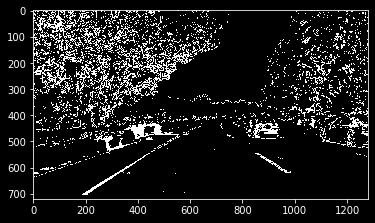

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Function calculates the directional gradient and applies given thresholds as binary mask
    INPUT:  img = RGB image
            orient = 'x' or 'y'
            sobel_kernel = Sobel kernel size, odd positive number
            threshold = Tuple of lower and upper threshold
    OUTPUT: binary image
    """
    # 1) Pick the value channel from HSV convertion
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    # 2) Take the derivative in given orientation = 'x' or 'y'
    sobel = cv2.Sobel(v, cv2.CV_64F, orient == 'x', orient == 'y')
    # 3) Take the absolute value of the derivative of gradient
    absSobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    uint8_sobel = np.uint8(255*absSobel/np.max(absSobel))
    # 5) Create a binary mask
    grad_binary = np.zeros_like(uint8_sobel)
    grad_binary[(uint8_sobel > thresh[0]) & (uint8_sobel < thresh[1])] = 1

    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Function calculates the gradient magnitude and applies given thresholds as binary mask
    INPUT:  img = RGB image
            sobel_kernel = Sobel kernel size, odd positive number
            threshold = Tuple of lower and upper threshold
    OUTPUT: binary image
    """
    # 1) Pick the value channel from HSV convertion
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(v, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(v, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(sobelx ** 2 + sobely ** 2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255 * magnitude / np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled > mag_thresh[0]) & (scaled < mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Function calculates the gradient direction and applies given thresholds as binary mask
    INPUT:  img = RGB image
            sobel_kernel = Sobel kernel size, odd positive number
            threshold = Tuple of lower and upper threshold
    OUTPUT: binary image
    """
    # 1) Pick the value channel from HSV convertion
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    # 2) Take the gradient in x and y separately
    xSobel = cv2.Sobel(v, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    ySobel = cv2.Sobel(v, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    x_abs = np.absolute(xSobel)
    y_abs = np.absolute(ySobel)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(y_abs, x_abs)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return dir_binary

def create_thresholded_binary_image(rgb_image):
    """
    Function takes in an RGB image and returns an thresholded binary image with the lane lines 
    """
    # Thresholds
    lower_s_threshold = 180
    upper_s_threshold = 255

    # Color conversions
    hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    s_hls = hls[:,:,2]

    # Color thresholds
    color_based_threshold = (s_hls > lower_s_threshold) & (s_hls <= upper_s_threshold)

    # Sobel thresholds
    ksize = 3 # Sobel kernel size

    gradx = abs_sobel_thresh(rgb_image, orient='x', sobel_kernel=ksize, thresh=(20, 100)) #20, 50
    grady = abs_sobel_thresh(rgb_image, orient='y', sobel_kernel=ksize, thresh=(20, 100)) #20, 50
    mag_binary = mag_thresh(rgb_image, sobel_kernel=ksize, mag_thresh=(40, 75))
    dir_binary = dir_threshold(rgb_image, sobel_kernel=ksize, thresh=(0, 1.28))

    sobel_based_threshold = ((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))

    # Binary image creation
    binary = np.zeros_like(s_hls)
    binary[(color_based_threshold | sobel_based_threshold)] = 1

    return binary

thresholded_img = create_thresholded_binary_image(undistort_img)
plt.imsave("output_images/thresholded_image.jpg", thresholded_img)
plt.imshow(thresholded_img, cmap="gray")

## Transformation to "bird-view"

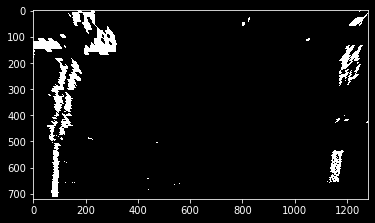

In [8]:
def transform_road(binary_image):

    # Image size
    xsize = binary_image.shape[1]
    ysize = binary_image.shape[0]

    
    # Display Area on binary Image
    #cv2.line(binary_image, (90, ysize), (557, 465), 1, thickness=5)
    #cv2.line(binary_image, (735, 465), (557, 465), 1, thickness=5)
    #cv2.line(binary_image, (735, 465), (xsize-20, ysize), 1, thickness=5)
    #implot = plt.imshow(binary_image, cmap="gray")
    #plt.scatter(x=[560, 745, 130, xsize-125], y=[465, 465, ysize, ysize], c='r', s=40)
    #plt.show()

    # Select source points
    src = np.float32([[557, 465], [735, 465], [90, ysize], [xsize-20, ysize]])

    # Select destination points
    dest = np.float32([[0,0],[xsize,0],[0, ysize],[xsize,ysize]])

    # Perform transformation
    M = cv2.getPerspectiveTransform(src, dest)
    warped = cv2.warpPerspective(binary_image, M, (xsize, ysize), flags=cv2.INTER_LINEAR)

    return warped
    
transformed_img = transform_road(thresholded_img)
plt.imshow(transformed_img, cmap="gray")
plt.imsave("output_images/transformed_image.jpg", transformed_img)

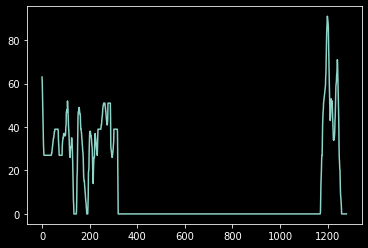

In [18]:
def showHistogram(trans_img, sixth):
    part_of_image = trans_img[int((sixth-1)*trans_img.shape[0]/6):int(sixth*trans_img.shape[0]/6), :]
    histogram = np.sum(part_of_image, axis=0)
    plt.plot(histogram)

showHistogram(transformed_img, 2)